# Analysis Organisation

This notebook illustrates how to organise your analysis or analyses. This presentation is based on the physical example of the analysis of $b \to u \ell \nu$ exclusive decays. The analysis properties are encoded in a companion file named `b-to-u-l-nu.yaml`, which fully describes a number of individual priors and likelihoods. These objects serve as the building blocks to construct individual posteriors, which are then available for the overall analysis.

## Defining the Building Blocks

The analysis file is loaded via [eos.AnalysisFile](../reference/python.rst#eos.AnalysisFile). In our case the file defines two posteriors `CKM-all` and `WET-all`, and a few priors and likelihoods, which are used to define the two posteriors. The file format is YAML.

In [1]:
import eos
import os
from IPython.display import Markdown as md

af = eos.AnalysisFile('./b-to-u-l-nu.yaml')

[ObservableEntries.insert_or_assign] Entry for observable B->pilnu::R_pi has been replaced.


### Defining parameters
The parametrization in EOS strives to be as specific as possible. Hence, EOS treats the Wilson coefficients as lepton flavor specific.  To restore lepton flavor universality, we create a new set of lepton flavor universal parameters and alias the existing parameters for the lepton specific Wilson coefficients to the new set.

Looking at the `b->u` parameters available in EOS, we see that all available Wilson coefficients are lepton flavor dependent:

In [2]:
display(eos.Parameters(prefix='ub', name='Re{cVL}'))

Here we show how to define a new parameter which is an alias to all three lepton flavor dependent left-handed vector Wilson coefficients:

```yaml
parameters:
  'ublnul::Re{cVL}' :
      alias_of: [ 'ubenue::Re{cVL}', 'ubmunumu::Re{cVL}', 'ubtaunutau::Re{cVL}' ]
      central:   1.0
      min:      -2.0
      max:       2.0
      unit:     '1'
      latex:    '$\mathrm{Re}\, \mathcal{C}^{\bar{u}b\bar{\nu}_\ell\ell}_{V_L}$'
  ...
```

The `alias_of` key is a list of existing EOS parameters (by qualified name).
In the `b-to-u-l-nu.yaml` analysis file we similarly do so for scalar and tensor Wilson coefficients.

### Defining priors

All priors are contained within a list associated with the top-level key `priors`. In the example, the `WET` prior is defined as follows:

```yaml
priors:
  ...
    - name: WET
    descriptions:
      - { 'parameter': 'ublnul::Re{cVL}', 'min':  0.9, 'max': 1.2, 'type': 'uniform' }
      ...
```

The definition associates a list of all parameters varied as part of this prior with the key `descriptions`. Each element of the list is a dictionary representing a single parameter. It provides the parameter's full name as `parameter`, lists the `min`/`max` interval, and specifies the `type` of prior distribution.
This format reflects the expectations of the `prior` keyword argument of [eos.Analysis](../reference/python.rst#eos.Analysis).

In addition to the `descriptions` key one can also pass manual constraints via the `manual_constraints` key or `pyhf` constraints via the `pyhf` key.

### Defining likelihoods

All likelihoods are contained within a list associated with the top-level key `likelihoods`. In the EOS convention, theoretical and experimental likelihoods should be defined separately from each other and their names prefixed with `TH-` and `EXP-`, respectively. In the example file, the `TH-pi` likelihoods is defined as follows:
```yaml
likelihoods:
  - name: TH-pi
    constraints:
      - 'B->pi::form-factors[f_+,f_0,f_T]@LMvD:2021A;form-factors=BCL2008-4'
      - 'B->pi::f_++f_0+f_T@FNAL+MILC:2015C;form-factors=BCL2008-4'
      - 'B->pi::f_++f_0@RBC+UKQCD:2015A;form-factors=BCL2008-4'
  ...
```
 The definition associates a list of constraints with the key `constraints`. Each element of the list is a string referring to one of the built-in [EOS constraints](https://eos.github.io/doc/reference/constraints). This format reflects the expectations of the `constraints` keyword argument of [eos.Analysis](../reference/python.rst#eos.Analysis).

### Defining posteriors

We define a posterior based on predefined likelihoods and priors within a list associated with the top-level key `posteriors` as
```yaml
posteriors:
  ...
  - name: WET-all
    global_options:
      model: WET
    fixed_parameters:
      CKM::abs(V_ub): 3.67e-3
    prior:
      - WET
      - DC-Bu
      - FF-pi
    likelihood:
      - TH-pi
      - EXP-pi
      - EXP-leptonic
```
The specification of global options ensures that we use the `CKM model` for CKM matrix elements and that we focus on electrons in our final state. Using the `fixed_parameters` key we fix $|V_{ub}|$ here.

In the analysis file we add two posteriors, for the `CKM model` and the `WET model`. Below we sample from both posteriors.

### Defining observables

By defining and using custom observables in this way, you can tailor your analysis to include specific quantities of interest and ensure that they are properly accounted for in your results. To define custom observables, one can add an entry to the `observables` part of the analysis file. Mandatory fields include the name of the observable, the `latex` expression, its `unit` and an `expression` for the observable. The `expression` is constructed as documented [here](../reference/desining-observables.rst).

```yaml
observables:
  "B->pilnu::R_pi":
    latex: "$R_{\\pi}$"
    unit: '1'
    options: {}
    expression: "<<B->pilnu::BR;l=tau>>[q2_min=>q2_tau_min] / <<B->pilnu::BR;l=e>>[q2_min=>q2_e_min]"
```

### Defining predictions

To finally produce posterior predictive distributions for some observables, we can add them via the `predictions` key:

```yaml
predictions:
  - name: leptonic-BR-CKM
    global_options:
      model: CKM
    observables:
      - name: B_u->lnu::BR;l=e
      - name: B_u->lnu::BR;l=mu
      - name: B_u->lnu::BR;l=tau
  ...
```

Here we add the total branching ratio of $\bar{B} \to \ell^- \bar{\nu}$ for $l=e, \mu, \tau$ as prediction.

Similarly, we can add a prediction for our custom observable, defined above:

```yaml
  - name : R_pi
    global_options:
      model: WET
    observables:
      - name: B->pilnu::R_pi
        kinematics:
          q2_e_min: 1.0e-7
          q2_tau_min: 3.3
          q2_max: 25.0
```

If interested, the differential branching ratio `B->pilnu::dBR/dq2` is also defined in the analysis file.

### Displaying the analysis file

The ``display`` command outputs the structure of the analysis file.

In [3]:
display(af)

## Running Frequent Tasks

Most analyses that use `EOS` follow a pattern:
  1. Define the priors, likelihoods, and posteriors.
  2. Sample from the posteriors.
  3. Inspect the posterior distributions for the analysis' parameters and plot them.
  4. Produce posterior-predictive distributions, e.g., for observables that have not yet been measured or that can not yet be used as part of a likelihood.

To facilitate running such analyses, `EOS` provides a number of repeated tasks within the `eos.tasks` module.
All tasks follow a simple pattern: they are functions that expect an `eos.AnalysisFile` (or its name) as their first argument, and at least one posterior as their second argument. Tasks can be run from within a Jupyter notebook or using the `eos-analysis` command-line program. Tasks store intermediate and final results within a hierarchy of directories. It is recommended to provide `EOS` with a base directory in which these data are stored. The command-line program inspects the `EOS_BASE_DIRECTORY` environment variable for this purpose.

In [4]:
BASE_DIRECTORY='./'

### Sampling from a Posterior

Markov Chain Monte Carlo (MCMC), as discussed in the previous examples, provides reasonable access to posterior samples for many low-dimensional parameter spaces. However, for high-dimensional parameter space or in the presence of multiple (local) modes of the posterior, other methods perform better.
`EOS` provides the `sample_nested` tasks, which uses the `dynesty` software to sample the posterior and compute its evidence using dynamic nested sampling.

Inputs to this sampling algorithm are
  - `nlive`: the number of live points;
  - `dlogz`: the maximal value for the remaining evidence;
  - `maxiter`: the maximal number of iterations; and
  - `bound`: the method to generate new live points.

For detailed information, see the `EOS` API and the `dynesty` documentation.

First, we sample from the `CKM model`. The task is then run as follows:

In [5]:
eos.tasks.sample_nested(af, 'CKM-all', base_directory=BASE_DIRECTORY, bound='multi', nlive=100, dlogz=9.0, maxiter=4000)

Accordion(children=(Output(layout=Layout(height='200px', overflow='auto')),), titles=('CKM-all/nested',))

Note that the above command uses an unreasonably large value for `dlogz` (9.0) and small values for `maxiter` (4000), which is only done for the sake of this example.
In practice, you should use a smaller value for `dlogz` at about 1% of the log-evidence. For `maxiter`, you should use a value that is large enough to ensure that the sampler has converged.
Ideally, no value for `maxiter` should be required.

We can access our results using the `eos.data` module. In the results summary we get an estimate for the log-evidence as the `logz` entry.

In [6]:
path = os.path.join(BASE_DIRECTORY, 'CKM-all', 'nested')
ns_results = eos.data.DynestyResults(path)

# Obtain dynesty results object
dyn_results = ns_results.results
# this can be used, for example, for a quick summary
dyn_results.summary()

Summary
niter: 4025
ncall: 110448
eff(%):  3.255
logz: 225.315 +/-  0.363


Finally, we can visualize our results using the `corner_plot` task:

Accordion(children=(Output(layout=Layout(height='200px', overflow='auto')),), titles=('CKM-all/plots',))

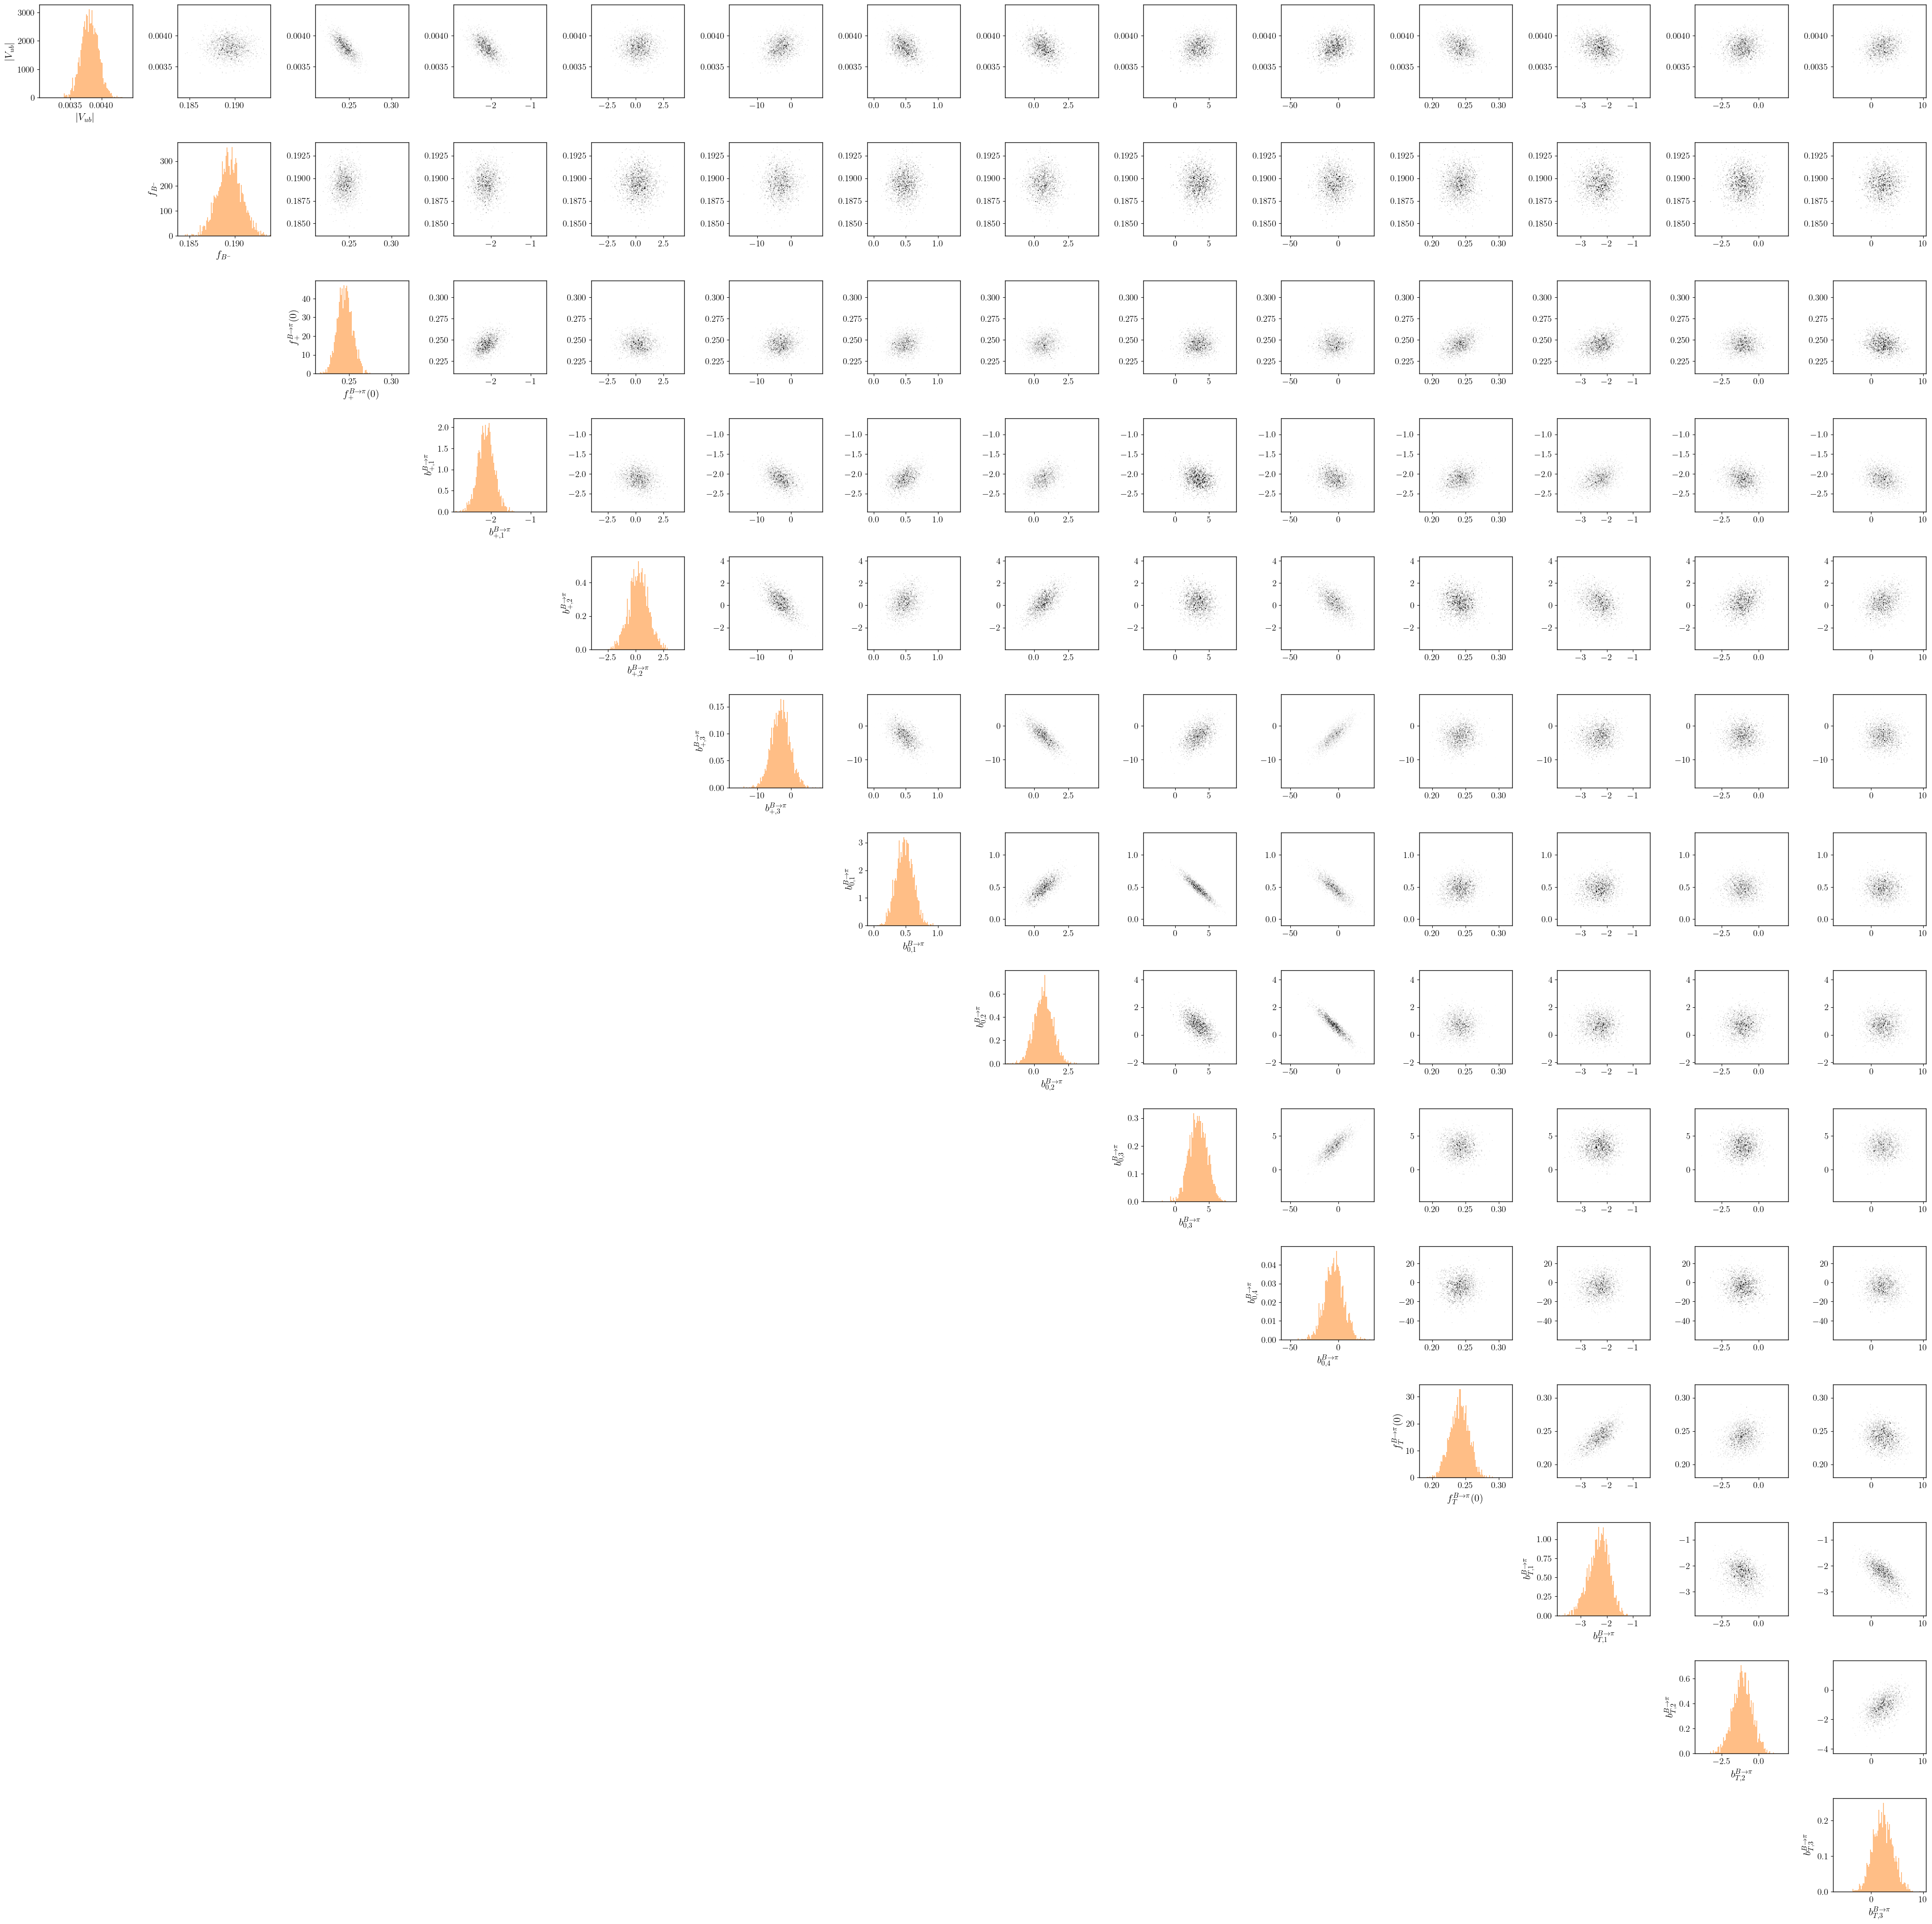

In [7]:
eos.tasks.corner_plot(analysis_file=af, posterior='CKM-all', base_directory=BASE_DIRECTORY, format=['pdf', 'png'])

To repeat this process for the `WET-all` posterior, we simply specify this in the task:

In [8]:
af = eos.AnalysisFile('./b-to-u-l-nu.yaml')

eos.tasks.sample_nested(af, 'WET-all', base_directory=BASE_DIRECTORY, bound='multi', nlive=100, dlogz=9.0, maxiter=4000)

[ObservableEntries.insert_or_assign] Entry for observable B->pilnu::R_pi has been replaced.


Accordion(children=(Output(layout=Layout(height='200px', overflow='auto')),), titles=('WET-all/nested',))

We can access our results using the `eos.data` module, as above:

In [9]:
path = os.path.join(BASE_DIRECTORY, 'WET-all', 'nested')
ns_results = eos.data.DynestyResults(path)

# Obtain dynesty results object
dyn_results = ns_results.results
# this can be used, for example, for a quick summary
dyn_results.summary()

Summary
niter: 4065
ncall: 117370
eff(%):  3.104
logz: 224.641 +/-  0.373


We can plot only part of the posterior by passing the `start` and `end` arguments to `eos.tasks.corner_plot`. Here we plot a marginal posterior for the Wilson coefficients.

Accordion(children=(Output(layout=Layout(height='200px', overflow='auto')),), titles=('WET-all/plots',))

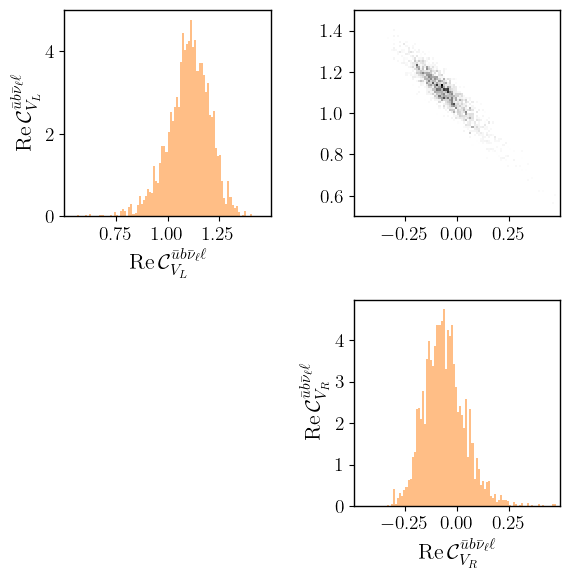

In [10]:
eos.tasks.corner_plot(analysis_file=af, posterior='WET-all', base_directory=BASE_DIRECTORY, format=['pdf', 'png'], end=2)

We can also generate posterior-predictive samples. Here we produce samples for the branching ratio of the leptonic decay $\bar{B} \to \ell^- \bar{\nu}$:

In [11]:
eos.tasks.predict_observables(
    analysis_file=af, posterior='CKM-all',
    prediction='leptonic-BR-CKM',
    base_directory=BASE_DIRECTORY
    )

Accordion(children=(Output(layout=Layout(height='200px', overflow='auto')),), titles=('CKM-all/pred-leptonic-B…

These samples can be analyzed as described in the [inference](inference.rst) notebook, e.g. with:

In [12]:
predictions = eos.data.Prediction('./CKM-all/pred-leptonic-BR-CKM')
lo, mi, up = eos.Plotter._weighted_quantiles(
        predictions.samples[:, 0], # Here 0 gives access to the prediction with the option l = e
        [0.15865, 0.5, 0.84135],
        predictions.weights
        )

md(f"""$\\mathcal{{B}}(\\bar{{B}} \\to e^- \\bar{{\\nu}}_e) = \
        {10**12*mi:.2f} ^ {{+{10**12*(up-mi):.2f}}} _ {{{10**12*(lo-mi):.2f}}} \\times 10^{{-12}}$
        (from a naive sampling)""")

$\mathcal{B}(\bar{B} \to e^- \bar{\nu}_e) =         9.82 ^ {+0.74} _ {-0.69} \times 10^{-12}$
        (from a naive sampling)

Similarly, for the `WET-all` posterior:

In [13]:
eos.tasks.predict_observables(
    analysis_file=af, posterior='WET-all',
    prediction='leptonic-BR-WET',
    base_directory=BASE_DIRECTORY
    )

Accordion(children=(Output(layout=Layout(height='200px', overflow='auto')),), titles=('WET-all/pred-leptonic-B…

In [14]:
predictions = eos.data.Prediction('./WET-all/pred-leptonic-BR-WET')
lo, mi, up = eos.Plotter._weighted_quantiles(
        predictions.samples[:, 0], # Here 0 gives access to the prediction with the option l = e
        [0.15865, 0.5, 0.84135],
        predictions.weights
        )

md(f"""$\\mathcal{{B}}(\\bar{{B}} \\to e^- \\bar{{\\nu}}_e) = \
        {10**12*mi:.2f} ^ {{+{10**12*(up-mi):.2f}}} _ {{{10**12*(lo-mi):.2f}}} \\times 10^{{-12}}$
        (from a naive sampling)""")

$\mathcal{B}(\bar{B} \to e^- \bar{\nu}_e) =         12.42 ^ {+4.06} _ {-3.89} \times 10^{-12}$
        (from a naive sampling)

Lastly, we can also make a prediction for our custom `R_pi` observable. Since this observable is constructed as the ratio of two branching ratios, which have the same functional form and parameter dependence, the uncertainties cancel almost exactly.

In [15]:
eos.tasks.predict_observables(
    analysis_file=af, posterior='CKM-all',
    prediction='R_pi',
    base_directory=BASE_DIRECTORY
    )

Accordion(children=(Output(layout=Layout(height='200px', overflow='auto')),), titles=('CKM-all/pred-R_pi',))

In [16]:
predictions = eos.data.Prediction('./CKM-all/pred-R_pi')
lo, mi, up = eos.Plotter._weighted_quantiles(
        predictions.samples[:, 0], # Here 0 gives access to the prediction with the option l = e
        [0.15865, 0.5, 0.84135],
        predictions.weights
        )

md(f"""$\\mathcal{{R}}_\pi = \
        {mi:.2g} ^ {{+{(up-mi):.2g}}} _ {{{(lo-mi):.2g}}}$
        (from a naive sampling)""")

$\mathcal{R}_\pi =         0.74 ^ {+1.1e-16} _ {-1.1e-16}$
        (from a naive sampling)